In [1]:
import json
import pandas as pd
import folium
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import time
import os
import csv 
from shapely.geometry import Point
from numpy import radians, sin, cos, arcsin, sqrt
import seaborn as sns
import branca.colormap as cm

** 读入Yelp文件 and filt philadelphia_business_df out

business_df (150346, 14) ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours']
       
Philadelphia_business_df 按照在Philadelphia地区cbgn内筛选的的（14563,15）, 多了一个geometry列，是Point

In [2]:
#控制操作文件

yelp_path='/data2/fanbingbing/data/Yelp/'
yelp_business_file_name = 'yelp_academic_dataset_business.json'

In [3]:
yelp_business_file_path = yelp_path+yelp_business_file_name

#json文件有多行 读取数据时要逐行阅读
all_data_temp=[]
with open(yelp_business_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data_temp = json.loads(line)
            all_data_temp.append(data_temp)
        except json.JSONDecodeError as e: #没有报错
            print(f"Error parsing JSON object on line: {file.lineno()} - {e}")
business_df = pd.DataFrame(all_data_temp)    

print(business_df.shape)
print(business_df.columns)
business_df.head(5)

(150346, 14)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
#folium 太大了打不开
# m = folium.Map(location=[29.9510658, -90.0715318], zoom_start=13)
# for index, row in business_df.iterrows():
#     # 从当前行中获取经纬度
#     lat = row['latitude']
#     lon = row['longitude']
# 
#     folium.Marker(
#         [lat, lon],
#         popup=f"<b>{row['name']}</b> - {row['city']}, {row['state']} ",
#         icon=folium.Icon(color='blue', icon='info-sign')
#     ).add_to(m)

In [77]:
# 使用 value_counts() 方法统计 city 列中每个唯一值的出现次数
city_counts = business_df['city'].value_counts()
print(city_counts.head(20))
state_counts = business_df['state'].value_counts()
print(state_counts.head(10))

Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Name: city, dtype: int64
PA    34039
FL    26330
TN    12056
IN    11247
MO    10913
LA     9924
AZ     9912
NJ     8536
NV     7715
AB     5573
Name: state, dtype: int64


In [42]:
Philadelphia_city_geojson = gpd.read_file('/data2/fanbingbing/data/city_geojson/philadelphia.geojson')
# Philadelphia_city_geojson.plot(figsize=(10,10), color = 'red')
# plt.show()
Philadelphia_city_cbgs = list(Philadelphia_city_geojson.census_block_group)
# len(Philadelphia_city_cbgs) #1336 CBG

In [81]:
#运行一次即可
business_df_filtered = []
# 遍历business_df中的每个商家
for index, row in tqdm.tqdm(business_df.iterrows()):
    point = Point(row['longitude'], row['latitude'])
    # 检查点是否在多边形边界内
    if any(polygon.contains(point) for polygon in Philadelphia_city_geojson.geometry):
        # 如果在边界内，将商家信息添加到business_df_filtered中
        business_df_filtered.append(row)

business_df_filtered = pd.DataFrame(business_df_filtered)
business_df_filtered.reset_index(drop=True, inplace=True)
business_df_filtered.drop(columns=['within_city'], inplace=True)
Philadelphia_business_df = business_df_filtered
del business_df_filtered

Philadelphia_business_df.to_csv('/data2/fanbingbing/data/Yelp/Philadelphia_business.csv',index=False)

Philadelphia_business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,geometry
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",POINT (-75.1555641 39.9555052)
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",POINT (-75.1432262 39.953949)
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",POINT (-75.162568 39.943223)
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",POINT (-75.1574465632 39.9398245705)
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1...",POINT (-75.218314 40.0224662)


** poi_datasets(safegraph)
poi_datasets_df  (20509, 14) 
['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name']
       


In [11]:
#运行一次即可
poi_all_features_df = pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_all_features.csv',usecols=['placekey', 'sum_visitors','poi_cbg',
       'distance_from_home', 'latitude', 'longitude', 'poi_category','poi_tract', 'same_category_number_in_tract']) #除此之外还有所在cbg的属性可以读

poi_segregation_df = pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia2019_segregationindex_includingoneflow.csv') #20509*5

poi_name_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_name.csv') #20509*2

poi_datasets_df = poi_all_features_df.merge(poi_segregation_df, on='placekey', how='inner')
poi_datasets_df = poi_datasets_df.merge(poi_name_df, on='placekey', how='inner')

poi_datasets_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_datasets.csv',index=False) #20509,14

poi_datasets_df.head()

(20509, 14)


,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,visitor_home_cbgs_income_level,visitor_home_cbgs_income_proportion,segregation_index,location_name
0,222-222@628-p77-c3q,4060.642717,421010353011,3325.416667,40.064966,-74.982909,Personal Services,4.210104e+10,4.0,"{'421010362033': 342.322012099125, '4210103550...","{'421010362033': 3.0, '421010355001': 3.0, '42...","{'sum': 4060.6427170093993, 'level_0': 180.721...",0.569269,Calhoun's Automotive Services
1,22s-222@628-p77-skf,18242.246507,421010353011,3120.916667,40.069060,-74.987539,Stores,4.210104e+10,3.0,"{'421010353011': 6176.586603080222, '421010353...","{'421010353011': 3.0, '421010353012': 3.0, '42...","{'sum': 18242.246507029075, 'level_0': 363.617...",0.557696,Designergemz
2,zzz-222@628-p77-bp9,36831.515984,421010353011,5019.750000,40.065487,-74.984842,"Arts, Cultural and Amussement Places",4.210104e+10,3.0,"{'421010353011': 7121.005053254798, '421010353...","{'421010353011': 3.0, '421010353013': 3.0, '42...","{'sum': 36831.51598386472, 'level_0': 2348.357...",0.461998,Fairmount Drainage Right Of Way
3,22j-222@628-p77-bp9,176256.404291,421010353011,2605.583333,40.064815,-74.985203,Health,4.210104e+10,11.0,"{'421010353011': 12598.206822782693, '42101035...","{'421010353011': 3.0, '421010352001': 3.0, '42...","{'sum': 176256.40429051258, 'level_0': 2921.26...",0.532006,ShopRite Pharmacy
4,zzw-225@628-p77-bx5,193.953013,421010353011,NaN,40.064958,-74.985765,Personal Services,4.210104e+10,4.0,"{'421010352001': 96.97650663167904, '421010353...","{'421010352001': 3.0, '421010353011': 3.0}","{'sum': 193.9530132633581, 'level_0': 0, 'leve...",1.000000,Supreme Nail Salon


*** 合并SafeGraph和Yelp数据
poi_datasets_df(safegraph) 20509*14

business_df(yelp)  14563*15
得到result_df  (5965, 23)
['placekey', 'sum_visitors', 'poi_cbg', 'distance_from_home', 'latitude',
       'longitude', 'poi_category', 'poi_tract',
       'same_category_number_in_tract', 'visitor_home_cbgs',
       'visitor_home_cbgs_income_level', 'visitor_home_cbgs_income_proportion',
       'segregation_index', 'location_name', 'business_id', 'name', 'address',
       'stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours']


In [14]:
poi_datasets_df = pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_datasets.csv').sort_values(by=['latitude', 'longitude'], ascending=[True, True])
business_df = pd.read_csv('/data2/fanbingbing/data/Yelp/Philadelphia_business.csv').sort_values(by=['latitude', 'longitude'], ascending=[True, True])

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,visitor_home_cbgs_income_level,visitor_home_cbgs_income_proportion,segregation_index,location_name
8682,zzw-223@63s-dw9-85f,35864.504167,421019804001,346439.333333,39.874388,-75.242411,Restaurants,4.210198e+10,16.0,"{'421010254001': 100.36443220626413, '42101001...","{'421010254001': 3.0, '421010016001': 3.0, '42...","{'sum': 35864.50416737617, 'level_0': 6155.210...",0.207396,Le Bus Cafe
8698,zzy-22c@63s-dw9-85f,31045.684744,421019804001,379990.416667,39.874399,-75.242405,Restaurants,4.210198e+10,16.0,"{'421010142002': 110.74933705537906, '42101008...","{'421010142002': 3.0, '421010087013': 1.0, '42...","{'sum': 31045.68474406721, 'level_0': 4194.396...",0.223962,Famous Famiglia
8676,zzw-222@63s-dw9-52k,218096.716703,421019804001,327750.000000,39.874539,-75.243771,Restaurants,4.210198e+10,16.0,"{'421019804001': 3140.2856024083653, '42101005...","{'421019804001': nan, '421010055003': 2.0, '42...","{'sum': 218096.7167030803, 'level_0': 44881.09...",0.113217,Independence Prime
5406,zzz-222@63s-dw6-89z,2534.611438,421019809001,27929.333333,39.875974,-75.211649,"Arts, Cultural and Amussement Places",4.210198e+10,6.0,"{'421019809001': 179.21563844558807, '42101025...","{'421019809001': nan, '421010257001': 2.0, '42...","{'sum': 2534.611438113188, 'level_0': 333.5305...",0.290911,Fort Mifflin
8700,zzy-224@63s-dw9-54v,38355.350995,421019804001,30614.083333,39.876114,-75.245686,Hotels,4.210198e+10,2.0,"{'421010161002': 97.926209514746, '42101033101...","{'421010161002': 1.0, '421010331012': 2.0, '42...","{'sum': 38355.35099496723, 'level_0': 7297.911...",0.177034,Minute Suites
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20330,zzw-222@63s-dwf-7yv,18072.781570,421010060002,5271.250000,NaN,NaN,NaN,4.210101e+10,NaN,"{'421010060002': 5832.198959116209, '421010027...","{'421010060002': 2.0, '421010027012': 2.0, '42...","{'sum': 18072.781569584808, 'level_0': 2434.32...",0.378710,NaN
20341,223-222@63s-dvq-k2k,8149.162982,421010081023,4112.166667,NaN,NaN,NaN,4.210101e+10,NaN,"{'421010081023': 1166.947212131058, '421010036...","{'421010081023': 0.0, '421010036002': 0.0, '42...","{'sum': 8149.162981734628, 'level_0': 4958.126...",0.477896,NaN
20430,255-222@63s-dvs-3bk,52967.943247,421010070002,3089.000000,NaN,NaN,NaN,4.210101e+10,NaN,"{'421010070002': 8000.051199869564, '421010070...","{'421010070002': 0.0, '421010070001': 1.0, '42...","{'sum': 52967.94324732853, 'level_0': 25002.07...",0.388274,NaN
20488,zzy-223@628-phn-5vf,125666.996074,421010260002,9188.500000,NaN,NaN,NaN,4.210103e+10,NaN,"{'421010260002': 12995.798807100588, '42101021...","{'421010260002': 2.0, '421010217003': 3.0, '42...","{'sum': 125666.99607424001, 'level_0': 26916.7...",0.247350,NaN


In [22]:
def disN7(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    d_lon = lon2 - lon1
    d_lat = lat2 - lat1
    aa = sin(d_lat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(d_lon / 2) ** 2
    bb=sqrt(aa)
    c = 2 * arcsin(bb)
    r = 6371
    return c * r

In [18]:
#先只按照名字相同匹配
matched_df = pd.merge(poi_datasets_df, business_df, left_on='location_name',right_on='name', how='inner', indicator=True)  

#找到在200米以内的
therohold = 0.2

# 对matched_df按照placekey进行分组
grouped = matched_df.groupby('placekey')
result_df = pd.DataFrame()

# 遍历每个分组
for (placekey, group) in tqdm.tqdm(grouped):
    # 如果这个placekey只有一行
    if len(group) == 1:
        disN7_value = disN7(group['longitude_x'].iloc[0], group['latitude_x'].iloc[0], group['longitude_y'].iloc[0], group['latitude_y'].iloc[0])
        if disN7_value < therohold:
            result_df = result_df.append(group)
    else:
        # 如果这个placekey不只有一行
        group['disN7'] = disN7(group['longitude_x'].iloc[0], group['latitude_x'].iloc[0], group['longitude_y'], group['latitude_y'])
        min_disN7_row = group[group['disN7'] == group['disN7'].min()]
        if min_disN7_row['disN7'].iloc[0] <therohold:
            result_df = result_df.append(min_disN7_row)

result_df

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude_x,longitude_x,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,...,latitude_y,longitude_y,stars,review_count,is_open,attributes,categories,hours,geometry,_merge
0,zzy-22c@63s-dw9-85f,31045.684744,421019804001,379990.416667,39.874399,-75.242405,Restaurants,4.210198e+10,16.0,"{'421010142002': 110.74933705537906, '42101008...",...,39.876751,-75.247162,2.0,20,0,"{'Ambience': ""{'romantic': False, 'intimate': ...","Restaurants, Pizza",NaN,POINT (-75.247162 39.876751),both
1,zzw-222@63s-dw9-52k,218096.716703,421019804001,327750.000000,39.874539,-75.243771,Restaurants,4.210198e+10,16.0,"{'421019804001': 3140.2856024083653, '42101005...",...,39.874557,-75.243750,3.5,108,1,"{'RestaurantsDelivery': 'False', 'RestaurantsR...","American (New), Restaurants","{'Monday': '5:0-0:0', 'Tuesday': '5:0-0:0', 'W...",POINT (-75.2437496274 39.8745568189),both
2,zzz-222@63s-dw6-89z,2534.611438,421019809001,27929.333333,39.875974,-75.211649,"Arts, Cultural and Amussement Places",4.210198e+10,6.0,"{'421019809001': 179.21563844558807, '42101025...",...,39.875325,-75.213082,4.0,22,1,NaN,"Landmarks & Historical Buildings, Public Servi...","{'Wednesday': '10:0-16:0', 'Thursday': '10:0-1...",POINT (-75.213082 39.8753247),both
3,zzy-222@63s-dw5-9s5,258.603379,421019809001,17209.454545,39.890844,-75.208763,"Arts, Cultural and Amussement Places",4.210198e+10,6.0,"{'421010271001': 67.73460516220375, '421010086...",...,39.875325,-75.213082,4.0,22,1,NaN,"Landmarks & Historical Buildings, Public Servi...","{'Wednesday': '10:0-16:0', 'Thursday': '10:0-1...",POINT (-75.213082 39.8753247),both
4,zzy-224@63s-dw9-54v,38355.350995,421019804001,30614.083333,39.876114,-75.245686,Hotels,4.210198e+10,2.0,"{'421010161002': 97.926209514746, '42101033101...",...,39.878918,-75.235748,4.0,72,1,"{'BusinessAcceptsBitcoin': 'False', 'HasTV': '...","Travel Services, Airports, Rest Stops, Airport...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",POINT (-75.235748291 39.8789176098),both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31162,223-223@628-pzn-zs5,2367.391638,421010365012,4045.750000,40.134124,-75.010555,Personal Services,4.210104e+10,5.0,"{'421010345012': 88.16820958797868, '421010359...",...,39.962183,-75.172190,3.5,42,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Hair Salons, Beauty & Spas","{'Monday': '0:0-0:0', 'Tuesday': '9:0-20:0', '...",POINT (-75.1721897 39.9621826),both
31163,223-223@628-pzn-zs5,2367.391638,421010365012,4045.750000,40.134124,-75.010555,Personal Services,4.210104e+10,5.0,"{'421010345012': 88.16820958797868, '421010359...",...,40.032364,-75.214102,3.0,34,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Beauty & Spas, Hair Removal, Men's Hair Salons...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-20:0', '...",POINT (-75.214102 40.032364),both
31164,223-223@628-pzn-zs5,2367.391638,421010365012,4045.750000,40.134124,-75.010555,Personal Services,4.210104e+10,5.0,"{'421010345012': 88.16820958797868, '421010359...",...,40.050038,-75.063187,3.5,10,0,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Hair Salons, Beauty & Spas, Men's Hair Salons","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",POINT (-75.063187 40.050038),both
31165,223-223@628-pzn-zs5,2367.391638,421010365012,4045.750000,40.134124,-75.010555,Personal Services,4.210104e+10,5.0,"{'421010345012': 88.16820958797868, '421010359...",...,40.064829,-74.983655,4.0,11,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Beauty & Spas, Hair Salons, Cosmetics & Beauty...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-20:0', '...",POINT (-74.983655 40.064829),both


In [36]:
#调整
result_df.drop(columns= ['latitude_y', 'longitude_y', 'geometry', '_merge', 'disN7', 'city', 'state', 'postal_code'], inplace=True)
result_df.rename(columns={'latitude_x': 'latitude', 'longitude_x': 'longitude'}, inplace=True)
result_df.sort_values(by='placekey', inplace=True)
result_df.reset_index(drop=True, inplace=True)

#剔除访问量少的
result_df['different_cbg_num'] = [x.count(":") for x in result_df.visitor_home_cbgs_income_level]
result_df = result_df[result_df.different_cbg_num >= 5]
result_df = result_df[result_df.sum_visitors >= 500]
result_df

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,...,business_id,name,address,stars,review_count,is_open,attributes,categories,hours,different_cbg_num
0,222-222@628-p6z-b8v,11994.650695,421010351001,7150.500000,40.045721,-74.994275,Restaurants,4.210104e+10,5.0,"{'421010362023': 128.80225400678628, '42101033...",...,egnIRUFaiOFdXYReuproiw,Jimmy's Timeout Sports Pub,5001 Linden Ave,4.0,17,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsTab...","Bars, Restaurants, Sports Bars, Pubs, Sandwich...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...",59
2,222-222@628-p74-wtv,62957.124151,421010331012,1506.583333,40.038745,-75.036203,Bars and Drinking Places,4.210103e+10,5.0,"{'421010331011': 3727.1850262015905, '42101033...",...,0jJf0DNHvYI0itdQSezsgg,Dunkin',7500 Frankford Ave,3.0,17,1,"{'WiFi': ""'free'"", 'RestaurantsTakeOut': 'True...","Food, Restaurants, Donuts, Coffee & Tea","{'Monday': '4:30-0:0', 'Tuesday': '4:30-0:0', ...",206
3,222-222@628-p77-2hq,6168.608214,421019891001,12798.583333,40.036244,-75.004551,"Arts, Cultural and Amussement Places",4.210199e+10,4.0,"{'421010330006': 304.59537822175304, '42101033...",...,kquD6fV5OclW6Szn24Y-Gg,Holmesburg Fish & Game Protective Association,5100 Pennypack St,4.5,10,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Gun/Rifle Ranges, Active Life","{'Monday': '7:0-22:0', 'Tuesday': '15:0-22:0',...",36
4,222-222@628-p7b-hnq,8987.587392,421010348023,3540.166667,40.056903,-75.013343,Personal Services,4.210103e+10,2.0,"{'421010348013': 582.0269057934444, '421010381...",...,ImskA2HuVbTc9KQtH0kIjw,Quality Discount Tire Service Center,3219 Willits Rd,2.5,13,1,NaN,"Automotive, Wheel & Rim Repair, Tires, Auto Re...","{'Monday': '9:0-17:30', 'Tuesday': '9:0-17:30'...",70
5,222-222@628-p7b-rc5,4624.204464,421010346001,13408.250000,40.069881,-75.017379,Stores,4.210103e+10,28.0,"{'421010383002': 166.61251787160418, '42101026...",...,eWbDxvMtmQR0zcKU6Drzsg,Asian World of Martial Arts,9400 Ashton Rd,2.0,11,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Martial Arts, Sporting Goods, Fashion, Sports ...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3...",31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5960,zzz-222@628-pmf-rp9,76745.783483,421010014001,6118.333333,39.942041,-75.171289,"Arts, Cultural and Amussement Places",4.210100e+10,3.0,"{'421010014001': 5494.547631427085, '421010019...",...,DUb37wPM8xzM3HJtniNtOQ,Marian Anderson Recreation Center,740 S 17th St,4.0,5,1,{'GoodForKids': 'True'},"Recreation Centers, Active Life, Local Flavor","{'Monday': '13:0-22:0', 'Tuesday': '13:0-22:0'...",304
5961,zzz-222@628-pnx-7dv,18821.952740,421010142002,6611.916667,39.965759,-75.141877,"Arts, Cultural and Amussement Places",4.210101e+10,20.0,"{'421010142002': 3510.7908274450197, '42101036...",...,FfBslprOhObk8m4QcgUGcw,Liberty Lands,913-961 N 3rd St,4.0,19,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Playgrounds, Parks, Active Life",NaN,109
5962,zzz-222@628-pnx-jjv,24453.955346,421010142002,7204.833333,39.966090,-75.129285,"Arts, Cultural and Amussement Places",4.210101e+10,20.0,"{'421010086022': 203.6819136274839, '421010179...",...,Bawf-t1gcb4TAxS4NRSqhg,Penn Treaty Park,1199 N Delaware Ave,4.5,50,1,"{'GoodForKids': 'True', 'BusinessParking': ""{'...","Parks, Lakes, Active Life, Local Flavor",NaN,228
5963,zzz-222@63s-dvy-649,19800.887506,421010078003,2519.250000,39.947928,-75.221938,"Arts, Cultural and Amussement Places",4.210101e+10,6.0,"{'421010062004': 71.77201622600371, '421010078...",...,uUYr4mxdptgy8faIxB-8Ew,Cedar Park,50th St & Baltimore Ave,4.5,8,1,"{'GoodForKids': 'True', 'BikeParking': 'True'}","Active Life, Parks",NaN,147


In [37]:
result_df.to_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp.csv',index=False)

*** 一些数据分析

In [9]:
result_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia_poi_with_yelp.csv')
result_df.head(200)

,placekey,sum_visitors,poi_cbg,distance_from_home,latitude,longitude,poi_category,poi_tract,same_category_number_in_tract,visitor_home_cbgs,...,business_id,name,address,stars,review_count,is_open,attributes,categories,hours,different_cbg_num
0,222-222@628-p6z-b8v,11994.650695,421010351001,7150.500000,40.045721,-74.994275,Restaurants,4.210104e+10,5.0,"{'421010362023': 128.80225400678628, '42101033...",...,egnIRUFaiOFdXYReuproiw,Jimmy's Timeout Sports Pub,5001 Linden Ave,4.0,17,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsTab...","Bars, Restaurants, Sports Bars, Pubs, Sandwich...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...",59
1,222-222@628-p74-wtv,62957.124151,421010331012,1506.583333,40.038745,-75.036203,Bars and Drinking Places,4.210103e+10,5.0,"{'421010331011': 3727.1850262015905, '42101033...",...,0jJf0DNHvYI0itdQSezsgg,Dunkin',7500 Frankford Ave,3.0,17,1,"{'WiFi': ""'free'"", 'RestaurantsTakeOut': 'True...","Food, Restaurants, Donuts, Coffee & Tea","{'Monday': '4:30-0:0', 'Tuesday': '4:30-0:0', ...",206
2,222-222@628-p77-2hq,6168.608214,421019891001,12798.583333,40.036244,-75.004551,"Arts, Cultural and Amussement Places",4.210199e+10,4.0,"{'421010330006': 304.59537822175304, '42101033...",...,kquD6fV5OclW6Szn24Y-Gg,Holmesburg Fish & Game Protective Association,5100 Pennypack St,4.5,10,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Gun/Rifle Ranges, Active Life","{'Monday': '7:0-22:0', 'Tuesday': '15:0-22:0',...",36
3,222-222@628-p7b-hnq,8987.587392,421010348023,3540.166667,40.056903,-75.013343,Personal Services,4.210103e+10,2.0,"{'421010348013': 582.0269057934444, '421010381...",...,ImskA2HuVbTc9KQtH0kIjw,Quality Discount Tire Service Center,3219 Willits Rd,2.5,13,1,NaN,"Automotive, Wheel & Rim Repair, Tires, Auto Re...","{'Monday': '9:0-17:30', 'Tuesday': '9:0-17:30'...",70
4,222-222@628-p7b-rc5,4624.204464,421010346001,13408.250000,40.069881,-75.017379,Stores,4.210103e+10,28.0,"{'421010383002': 166.61251787160418, '42101026...",...,eWbDxvMtmQR0zcKU6Drzsg,Asian World of Martial Arts,9400 Ashton Rd,2.0,11,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Martial Arts, Sporting Goods, Fashion, Sports ...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3...",31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,222-222@628-pmf-8vz,12971.712981,421010369003,2948.416667,39.953047,-75.192644,Restaurants,4.210104e+10,59.0,"{'421010369003': 2061.1555297143886, '42101008...",...,4o0xTz_indIcqzJ7juHBAw,KQ Burger,3401 Walnut St,2.5,19,1,"{'Alcohol': ""u'none'"", 'OutdoorSeating': 'True...","Restaurants, Fast Food, Bars, Sandwiches, Burg...","{'Monday': '11:0-16:0', 'Tuesday': '11:0-16:0'...",83
196,222-222@628-pmf-ht9,45434.700141,421010004022,23635.583333,39.952982,-75.170258,Bars and Drinking Places,4.210100e+10,32.0,"{'421010004022': 3225.1878887616135, '42101006...",...,X7TvrNg6jY1Q0JHJXjlQ2g,ArtBar,1800 Market St,3.0,36,1,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...","Food, Hotels & Travel, Coffee & Tea, Event Pla...","{'Monday': '6:30-2:0', 'Tuesday': '6:30-2:0', ...",350
197,222-222@628-pmf-j5f,6261.033397,421010008041,14850.666667,39.949778,-75.170009,Stores,4.210100e+10,32.0,"{'421010008041': 350.72011336112683, '42101002...",...,_qJld4xqJfDv76BCu9cY1Q,Madewell,1716 Walnut St,4.0,21,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Shoe Stores, Shopping, Accessories, Fashion, W...","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0'...",75
198,222-222@628-pmf-j7q,21957.630844,421010007002,16305.166667,39.950790,-75.170694,Restaurants,4.210100e+10,97.0,"{'421010237003': 111.99513061809583, '42101000...",...,gy0NuW7nzIuZNq3lLLlgzA,Serafina Philadelphia,130 S 18th St,2.5,292,0,"{'NoiseLevel': ""u'average'"", 'BikeParking': 'F...","Italian, Restaurants","{'Monday': '11:30-0:0', 'Tuesday': '11:30-0:0'...",188


In [38]:
#计算相关性
correlations = result_df[['segregation_index', 'sum_visitors', 'distance_from_home', 'latitude', 'longitude', 'same_category_number_in_tract', 'stars', 'review_count', 'is_open']].corr()
print(correlations)

                               segregation_index  sum_visitors  \
segregation_index                       1.000000     -0.165267   
sum_visitors                           -0.165267      1.000000   
distance_from_home                     -0.083020     -0.013349   
latitude                                0.135235      0.047195   
longitude                              -0.032545      0.063217   
same_category_number_in_tract          -0.095657     -0.043549   
stars                                   0.144924     -0.185646   
review_count                            0.016785     -0.017887   
is_open                                -0.042676      0.076995   

                               distance_from_home  latitude  longitude  \
segregation_index                       -0.083020  0.135235  -0.032545   
sum_visitors                            -0.013349  0.047195   0.063217   
distance_from_home                       1.000000 -0.137660  -0.070279   
latitude                                -0.

In [7]:
#统计种类
print(result_df['poi_category'].value_counts())

Restaurants                                         2689
Bars and Drinking Places                             727
Stores                                               602
Personal Services                                    292
Arts, Cultural and Amussement Places                 292
Grocery Stores                                       275
Health                                               214
Others                                                76
Hotels                                                37
Professional, Scientific, and Technical Services      29
Real Estate                                           24
Transportation                                        18
School                                                16
Financial                                             14
Gasoline Stations                                     12
Information Services                                  11
Religious Organizations                                7
Name: poi_category, dtype: int6

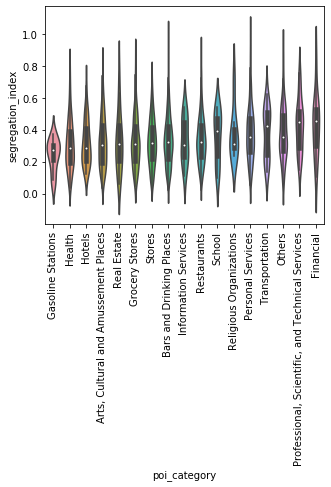

In [41]:
draw_ord = list(result_df.groupby('poi_category', as_index = False).agg('mean').sort_values('segregation_index').poi_category)
plt.figure(figsize = (5, 4))
sns.violinplot(x='poi_category', y='segregation_index', data=result_df, order = draw_ord)
plt.xticks(rotation = 90)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


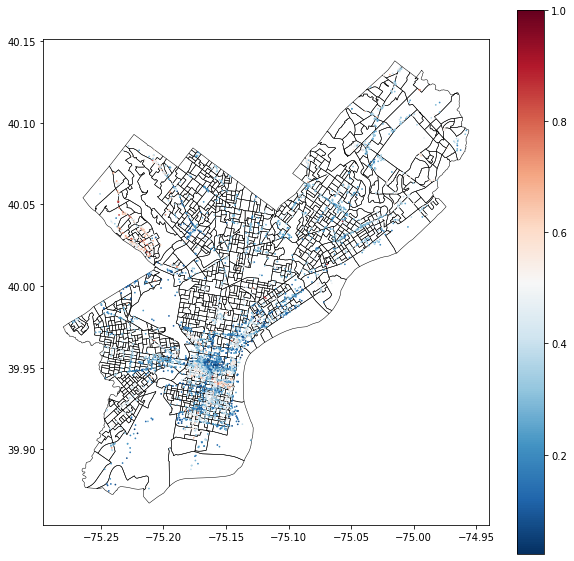

In [49]:
# 绘制经纬度点，根据segregation_index列设置颜色
ax = Philadelphia_city_geojson.boundary.plot(figsize=(10,10),color='black', linewidth=0.5)
sc = ax.scatter(result_df['longitude'], result_df['latitude'], c=result_df['segregation_index'], cmap='RdBu_r', zorder=5,s=0.5)
plt.colorbar(sc)
plt.savefig('segregation_chicago.png', dpi=300)
plt.show()

In [52]:
# 创建地图对象，并设置中心点为芝加哥的经纬度坐标
m = folium.Map(location=[39.57, -75.10], zoom_start=12)
colormap = cm.linear.RdBu_07
# 添加经纬度点
for idx, row in result_df.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=5,
                        color=None,  # 设置边框颜色为None，即无边框
                        fill_color=colormap(row['segregation_index']), 
                        fill_opacity=1,
                        popup=f"name: {row['name']}<br>Sum Visitors: {row['sum_visitors']}<br>Segregation Index: {row['segregation_index']}<br>poi category: {row['poi_category']}<br>stars: {row['stars']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}<br>distance from home': {row['distance_from_home']}").add_to(m)  # 点击弹出数据
# 将colormap添加到地图上
colormap.caption = 'Segregation Index'
m.add_child(colormap)
m.save("/data2/fanbingbing/data/segregation/philadelphia/poi_with_yelp.html")

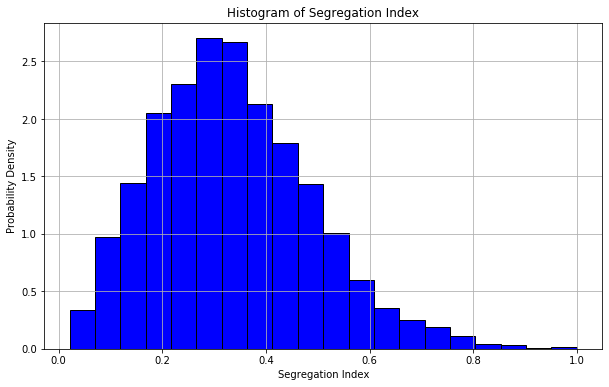

In [16]:
#看index分布
plt.figure(figsize=(10, 6))  # 可以调整图表大小
result_df['segregation_index'].hist(bins=20,density=True,color='blue', edgecolor='black') 
plt.title('Histogram of Segregation Index')  # 设置图表标题
plt.xlabel('Segregation Index')  # 设置x轴标签
plt.ylabel('Probability Density')  # 设置y轴标签
# plt.tight_layout()  # 调整布局以防止标签重叠
plt.show()  # 显示图表

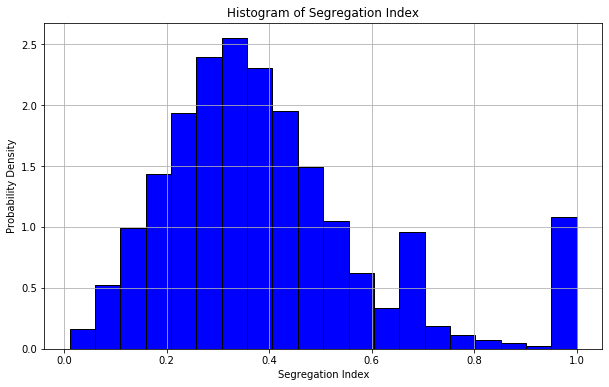

In [17]:
safegraph_df=pd.read_csv('/data2/fanbingbing/data/segregation/philadelphia/philadelphia2019_segregationindex_includingoneflow.csv')
plt.figure(figsize=(10, 6))  # 可以调整图表大小
safegraph_df['segregation_index'].hist(bins=20,density=True,color='blue', edgecolor='black') 
plt.title('Histogram of Segregation Index')  # 设置图表标题
plt.xlabel('Segregation Index')  # 设置x轴标签
plt.ylabel('Probability Density')  # 设置y轴标签
# plt.tight_layout()  # 调整布局以防止标签重叠
plt.show()  # 显示图表